In [7]:
import os
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf  # Library to save .wav files
from scipy.signal import butter, filtfilt
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, find_peaks
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import pywt

In [ ]:


################# Denoisation of soundwaves ##################



# Define paths
wav_folder_path = "D:\ISI internship\WAV_files"
hea_folder_path = "D:\ISI internship\HEA_files"
tsv_folder_path = "D:\ISI internship\TSV_files"
output_folder_path = "D:\ISI internship\denoised_recordings"  # Path to save denoised files

# Create output folder if it doesn't exist
os.makedirs(output_folder_path, exist_ok=True)

# Function to read the .hea file and extract metadata
def read_hea_file(hea_file_path):
    metadata = {}
    with open(hea_file_path, 'r') as file:
        first_line = file.readline().strip().split()
        metadata['record_name'] = first_line[0]
        metadata['channels'] = int(first_line[1])
        metadata['sample_rate'] = int(first_line[2])
        metadata['samples'] = int(first_line[3])
    return metadata

# Function to read the .tsv file and extract segments (S1, S2, systole, diastole)
def read_tsv_file(tsv_file_path):
    tsv_data = pd.read_csv(tsv_file_path, sep='\t', header=None)
    events = {
        'start_time': tsv_data[0].values,
        'end_time': tsv_data[1].values,
        'label': tsv_data[2].values  # Assuming the 3rd column contains labels like S1, S2, systole, diastole
    }
    return events

# Function for wavelet denoising
def wavelet_denoise(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    # Thresholding - can be adjusted
    threshold = np.sqrt(2 * np.log(len(signal))) * np.median(np.abs(coeffs[-1]))  # Universal threshold
    coeffs_denoised = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    denoised_signal = pywt.waverec(coeffs_denoised, wavelet)
    return denoised_signal[:len(signal)]  # Match the original length

# Process each .wav file in the folder
for file in os.listdir(wav_folder_path):
    if file.endswith('.wav'):
        wav_file_path = os.path.join(wav_folder_path, file)
        hea_file_path = os.path.join(hea_folder_path, file.replace('.wav', '.hea'))
        tsv_file_path = os.path.join(tsv_folder_path, file.replace('.wav', '.tsv'))

        # Check if the .hea and .tsv files exist
        if not os.path.exists(hea_file_path):
            print(f"Warning: HEA file not found for {file}. Skipping this file.")
            continue
        if not os.path.exists(tsv_file_path):
            print(f"Warning: TSV file not found for {file}. Skipping this file.")
            continue

        # Read .hea file to get metadata
        hea_metadata = read_hea_file(hea_file_path)
        print(f"Loaded .hea file with metadata: {hea_metadata}")

        # Load the .wav file using the sample rate from the .hea file
        try:
            samples, sample_rate = librosa.load(wav_file_path, sr=hea_metadata['sample_rate'])
        except Exception as e:
            print(f"Error loading {file}: {e}. Skipping this file.")
            continue

        # Read the .tsv file for event timings (e.g., S1, S2)
        events = read_tsv_file(tsv_file_path)

        # Denoise each segment based on .tsv timings and save the denoised audio
        for start_time, end_time, label in zip(events['start_time'], events['end_time'], events['label']):
            start_sample = int(start_time * sample_rate)
            end_sample = int(end_time * sample_rate)
            segment = samples[start_sample:end_sample]

            # Check if the segment is valid
            if len(segment) > 0:
                # Denoise the segment
                denoised_segment = wavelet_denoise(segment)

                # Save the denoised segment as a new .wav file
                denoised_file_name = f"{os.path.splitext(file)[0]}_{label}.wav"
                denoised_file_path = os.path.join(output_folder_path, denoised_file_name)
                sf.write(denoised_file_path, denoised_segment, sample_rate)  # Use soundfile to save WAV files

                print(f"Denoised segment {label} saved as {denoised_file_name}")
            else:
                print(f"Warning: Segment for {label} in {file} is empty. Skipping this segment.")

print("Denoising complete.")


In [ ]:

############# Filted using butterworth #############



# Butterworth high-pass filter function
def butter_highpass(cutoff, sample_rate, order=4):
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def apply_butter_highpass(samples, sample_rate, cutoff=50, order=4):
    b, a = butter_highpass(cutoff, sample_rate, order=order)
    filtered_samples = filtfilt(b, a, samples)
    return filtered_samples

# Define the path to the folder containing .wav files
input_folder_path = "D:\ISI internship\denoised_recordings"


# Iterate through all files in the folder
for file in os.listdir(input_folder_path):
    if file.endswith('.wav'):
        # Full file paths
        file_path = os.path.join(input_folder_path, file)
        

        # Load the audio file using librosa
        samples, sample_rate = librosa.load(file_path, sr=None)

        # Apply Butterworth high-pass filter
        filtered_samples = apply_butter_highpass(samples, sample_rate)

       

        # Plot the original and filtered signals
        plt.figure(figsize=(14, 6))

        # Plot the original waveform
        plt.subplot(2, 1, 1)
        plt.plot(np.arange(len(samples)) / sample_rate, samples, label='Original Signal', color='b')
        plt.title(f"Original Phonocardiogram - {file}")
        plt.xlabel('Time [seconds]')
        plt.ylabel('Amplitude')
        plt.grid()

        # Plot the filtered waveform
        plt.subplot(2, 1, 2)
        plt.plot(np.arange(len(filtered_samples)) / sample_rate, filtered_samples, label='Filtered Signal', color='r')
        plt.title(f"Filtered Phonocardiogram (Butterworth High-Pass) - {file}")
        plt.xlabel('Time [seconds]')
        plt.ylabel('Amplitude')
        plt.grid()

        plt.tight_layout()
        plt.show()

In [ ]:


############  finding S1,S2 peaks according to the annotations  #############


# Define paths
wav_folder_path = "D:\ISI internship\Saved_from_Filter\WAV_Files"
tsv_folder_path = "D:\ISI internship\Saved_from_Filter\TSV_Files"
hea_folder_path = "D:\ISI internship\Saved_from_Filter\HEA_Files"

# Function to read the .hea file and extract metadata
def read_hea_file(hea_file_path):
    metadata = {}
    with open(hea_file_path, 'r') as file:
        first_line = file.readline().strip().split()
        metadata['record_name'] = first_line[0]
        metadata['channels'] = int(first_line[1])
        metadata['sample_rate'] = int(first_line[2])
        metadata['samples'] = int(first_line[3])
    return metadata

# Function to extract the envelope using Hilbert Transform
def extract_envelope(signal):
    analytic_signal = hilbert(signal)
    envelope = np.abs(analytic_signal)
    return envelope

# Function to segment heart sounds
def segment_heart_sounds(signal, sample_rate):
    envelope = extract_envelope(signal)
    peaks, _ = find_peaks(envelope, height=np.max(envelope) * 0.3, distance=0.3 * sample_rate)

    systole = []
    diastole = []
    
    for i in range(1, len(peaks) - 1, 2):
        s1 = peaks[i - 1]
        s2 = peaks[i]
        systole.append(signal[s1:s2])
        if i + 1 < len(peaks):
            next_s1 = peaks[i + 1]
            diastole.append(signal[s2:next_s1])
    
    return peaks, systole, diastole

# Process each .wav file in the folder
for file in os.listdir(wav_folder_path):
    if file.endswith('.wav'):
        wav_file_path = os.path.join(wav_folder_path, file)
        hea_file_path = os.path.join(hea_folder_path, file.replace('.wav', '.hea'))

        # Read .hea file to get metadata
        hea_metadata = read_hea_file(hea_file_path)
        print(f"Loaded .hea file with metadata: {hea_metadata}")

        # Load the .wav file using the sample rate from the .hea file
        samples, sample_rate = librosa.load(wav_file_path, sr=hea_metadata['sample_rate'])

        # Segment the heart sounds
        peaks, systole, diastole = segment_heart_sounds(samples, sample_rate)

        # Plotting results
        plt.figure(figsize=(14, 6))
        time_axis = np.arange(len(samples)) / sample_rate
        plt.plot(time_axis, samples, label='Heart Sound Signal', color='b')
        plt.scatter(peaks / sample_rate, samples[peaks], color='r', label='Detected Peaks')
        
        plt.title(f"Heart Sound Segmentation - {file}")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid()
        plt.show()


In [ ]:

################ S1,S2, SYSTOLE, DYSTOLE visualization ###############


output_folder = "D:\\ISI internship\\visualisation"

# Ensure output directory exists
os.makedirs(output_folder, exist_ok=True)

# Function to read the .hea file and extract metadata
def read_hea_file(hea_file_path):
    metadata = {}
    with open(hea_file_path, 'r') as file:
        first_line = file.readline().strip().split()
        metadata['record_name'] = first_line[0]
        metadata['channels'] = int(first_line[1])
        metadata['sample_rate'] = int(first_line[2])
        metadata['samples'] = int(first_line[3])
    return metadata

# Function to extract the envelope using Hilbert Transform
def extract_envelope(signal):
    analytic_signal = hilbert(signal)
    envelope = np.abs(analytic_signal)
    return envelope

# Function to segment heart sounds
def segment_heart_sounds(signal, sample_rate):
    envelope = extract_envelope(signal)
    peaks, _ = find_peaks(envelope, height=np.max(envelope) * 0.3, distance=0.3 * sample_rate)
    return peaks

# Color mapping for events
color_map = {
    1: 'red',     # S1
    2: 'green',   # S2
    3: 'yellow',  # Systole
    4: 'blue',    # Diastole
    0: 'black'    # Default event
}

# Process each .wav file in the folder
for file in os.listdir(wav_folder_path):
    if file.endswith('.wav'):
        wav_file_path = os.path.join(wav_folder_path, file)
        hea_file_path = os.path.join(hea_folder_path, file.replace('.wav', '.hea'))
        tsv_file_path = os.path.join(tsv_folder_path, file.replace('.wav', '.tsv'))

        # Read .hea file to get metadata
        hea_metadata = read_hea_file(hea_file_path)
        print(f"Loaded .hea file with metadata: {hea_metadata}")

        # Load the .wav file using the sample rate from the .hea file
        samples, sample_rate = librosa.load(wav_file_path, sr=hea_metadata['sample_rate'])

        # Segment the heart sounds
        peaks = segment_heart_sounds(samples, sample_rate)

        # Load the .tsv file for annotations
        tsv_data = pd.read_csv(tsv_file_path, sep='\t', header=None, names=['start', 'end', 'event'])

        # Plotting results
        plt.figure(figsize=(14, 6))
        time_axis = np.arange(len(samples)) / sample_rate
        plt.plot(time_axis, samples, label='Heart Sound Signal', color='b')
        plt.scatter(peaks / sample_rate, samples[peaks], color='r', label='Detected Peaks')

        # Add labels to the peaks
        for idx, peak in enumerate(peaks):
            plt.text(peak / sample_rate, samples[peak], f'Peak {idx + 1}', color='red', fontsize=10, ha='center', va='bottom')

        # Plot annotations from the TSV file with color coding
        for idx, row in tsv_data.iterrows():
            start_time = row['start']
            end_time = row['end']
            event_label = row['event']
            color = color_map.get(int(event_label), 'black')  # Default to black if not found
            plt.axvspan(start_time, end_time, color=color, alpha=0.3, label=f'Event {event_label}' if idx == 0 else "")

        # Adding legend for events
        handles = [
            plt.Line2D([0], [0], color='red', lw=4, label='S1'),
            plt.Line2D([0], [0], color='green', lw=4, label='S2'),
            plt.Line2D([0], [0], color='yellow', lw=4, label='Systole'),
            plt.Line2D([0], [0], color='blue', lw=4, label='Diastole'),
            plt.Line2D([0], [0], color='black', lw=4, label='Default Event (0.0)')
        ]
        plt.legend(handles=handles)

        plt.title(f"Heart Sound Segmentation - {file}")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.grid()
        
        # Save the figure
        output_file_path = os.path.join(output_folder, f"{file.replace('.wav', '.png')}")
        plt.savefig(output_file_path)
        plt.close()  # Close the figure to free up memory


In [ ]:
pip install pandas librosa openpyxl

In [6]:
%pip install pyfftw

Note: you may need to restart the kernel to use updated packages.


In [ ]:

############# Feature Extraction ##################


# Define paths
output_excel_path = "D:\ISI internship\Extracted_Features\Extracted_Features2.csv"  # Path to save the Excel file

# Function to read the .hea file and extract metadata
def read_hea_file(hea_file_path):
    metadata = {}
    with open(hea_file_path, 'r') as file:
        first_line = file.readline().strip().split()
        metadata['record_name'] = first_line[0]
        metadata['channels'] = int(first_line[1])
        metadata['sample_rate'] = int(first_line[2])
        metadata['samples'] = int(first_line[3])
    return metadata

# Function to extract the envelope using Hilbert Transform
def extract_envelope(signal):
    analytic_signal = hilbert(signal)
    envelope = np.abs(analytic_signal)
    return envelope

# Function to segment heart sounds
def segment_heart_sounds(signal, sample_rate):
    envelope = extract_envelope(signal)
    peaks, _ = find_peaks(envelope, height=np.max(envelope) * 0.3, distance=0.3 * sample_rate)
    return peaks

# Function to extract features from the audio signal
def extract_features(signal, sample_rate):
    features = {}

    # Dynamically set n_fft based on the length of the signal

    n_fft = min(2048, len(signal))  # Ensure n_fft is not larger than the signal length

    # Time-domain features


    features['envelope'] = np.mean(extract_envelope(signal))  # Envelope
    features['amplitude'] = np.mean(signal)  # Amplitude
    features['energy'] = np.sum(signal ** 2)  # Energy
    features['entropy'] = -np.sum(np.square(signal) * np.log(np.square(signal) + 1e-10))  # Entropy
    features['loudness'] = np.mean(np.abs(signal))  # Loudness
    features['peak_amplitude'] = np.max(np.abs(signal))  # Peak Amplitude

    # Spectral features


    spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sample_rate, n_fft=n_fft)
    features['spectral_centroid'] = np.mean(spectral_centroid)  # Spectral Centroid

    return features
    
# List to hold all extracted features
all_features = []

# Process each .wav file in the folder
for file in os.listdir(wav_folder_path):
    if file.endswith('.wav'):
        wav_file_path = os.path.join(wav_folder_path, file)
        hea_file_path = os.path.join(hea_folder_path, file.replace('.wav', '.hea'))

        # Check if the .hea file exists
        if not os.path.exists(hea_file_path):
            print(f"Warning: HEA file not found for {file}. Skipping this file.")
            continue

        # Read .hea file to get metadata
        hea_metadata = read_hea_file(hea_file_path)
        print(f"Loaded .hea file with metadata: {hea_metadata}")

        # Load the .wav file using the sample rate from the .hea file
        try:
            samples, sample_rate = librosa.load(wav_file_path, sr=hea_metadata['sample_rate'])
        except Exception as e:
            print(f"Error loading {file}: {e}. Skipping this file.")
            continue

        # Segment the heart sounds
        peaks = segment_heart_sounds(samples, sample_rate)

        # Extract features for each segment
        for peak in peaks:
            start_idx = max(0, peak - int(0.1 * sample_rate))  # 100 ms before peak
            end_idx = min(len(samples), peak + int(0.1 * sample_rate))  # 100 ms after peak
            segment = samples[start_idx:end_idx]

            features = extract_features(segment, sample_rate)
            features['filename'] = file  # Add filename for reference
            all_features.append(features)  # Append to the list

# Create a DataFrame from the collected features
features_df = pd.DataFrame(all_features)

# Save to Excel
features_df.to_excel(output_excel_path, index=False)
print(f"Features saved to {output_excel_path}")


In [ ]:

# Load your CSV file
df = pd.read_csv("D:\ISI internship\Extracted_Features\Extracted_Features2.csv")

# Replace missing values with NaN
df.replace("", np.nan, inplace=True)  # Replace empty strings with NaN
df.fillna(value=np.nan, inplace=True)  # Optional: ensures any None or NaN values are maintained

# Save the updated DataFrame back to a CSV if needed
df.to_csv("D:\ISI internship\Extracted_Features\cleaned_features.csv", index=False)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# Load your dataset
df = pd.read_csv("path/to/your/file.csv")

# Initialize KNN Imputer
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors

# Apply KNN Imputer to fill NaN values
# If you have categorical data, you may need to handle it separately.
filled_data = imputer.fit_transform(df)

# Convert the filled data back to a DataFrame
df_filled = pd.DataFrame(filled_data, columns=df.columns)

# Save the updated DataFrame back to a CSV if needed
df_filled.to_csv("D:\ISI internship\Extracted_Features\KNN_Cleaned_features.csv", index=False)

# Display the DataFrame with filled values
print(df_filled)


In [19]:
import pandas as pd

# Load your feature dataset
features_df = pd.read_csv("D:\\ISI internship\\Extracted_Features\\KNN_Cleaned_features.csv")

# Load the original outcomes dataset
outcomes_df = pd.read_csv("D:\\ISI internship\\the-circor-digiscope-phonocardiogram-dataset-1.0.3\\training_data.csv")

# Check the structure of both datasets
print("Features Dataset:")
print(features_df.head())

print("Outcomes Dataset:")
print(outcomes_df.head())


Features Dataset:
   envelope_mean  amplitude_mean    energy  loudness  peak_amplitude  \
0       0.003804       -0.000014  0.007032  0.002396        0.011322   
1       0.013279       -0.000097  0.064746  0.008531        0.030945   
2       0.025224       -0.000085  0.657972  0.015673        0.230499   
3       0.091805       -0.000282  4.819567  0.058834        0.554077   
4       0.004505        0.000012  0.012908  0.002881        0.014435   

   spectral_centroid_mean  spectral_entropy  spectral_rolloff  spectral_flux  \
0              283.146673     -9.052971e+05        762.695312       2.208607   
1              266.533582     -7.935896e+05        415.039062       8.302711   
2              272.118067     -8.302639e+05        460.937500       3.573044   
3              209.504607     -4.691851e+05        281.250000      13.461571   
4              516.318296     -3.330560e+06        958.984375      10.034902   

                                               mfccs  \
0  -468.5026

In [20]:
# Extract patient ID from the filename
features_df['id'] = features_df['filename'].str.extract(r'(\d+)')


In [23]:
# Check the data types of both columns
print("Features Dataset 'id' data type:", features_df['id'].dtype)
print("Outcomes Dataset 'Patient ID' data type:", outcomes_df['Patient ID'].dtype)


Features Dataset 'id' data type: object
Outcomes Dataset 'Patient ID' data type: int64


In [24]:
# Convert 'Patient ID' to string if it is int
outcomes_df['Patient ID'] = outcomes_df['Patient ID'].astype(str)

# Alternatively, convert 'id' to int if it is a string (if you're sure all IDs can be converted)
# features_df['id'] = features_df['id'].astype(int)

# Check the data types again to confirm the change
print("Updated Features Dataset 'id' data type:", features_df['id'].dtype)
print("Updated Outcomes Dataset 'Patient ID' data type:", outcomes_df['Patient ID'].dtype)


Updated Features Dataset 'id' data type: object
Updated Outcomes Dataset 'Patient ID' data type: object


In [29]:
# Display the columns in the outcomes dataset
print("Outcomes Dataset Columns:")
print(outcomes_df.columns)


Outcomes Dataset Columns:
Index(['Patient ID', 'Recording locations:', 'Age', 'Sex', 'Height', 'Weight',
       'Pregnancy status', 'Murmur', 'Murmur locations',
       'Most audible location', 'Systolic murmur timing',
       'Systolic murmur shape', 'Systolic murmur grading',
       'Systolic murmur pitch', 'Systolic murmur quality',
       'Diastolic murmur timing', 'Diastolic murmur shape',
       'Diastolic murmur grading', 'Diastolic murmur pitch',
       'Diastolic murmur quality', 'original_outcome', 'Campaign',
       'Additional ID'],
      dtype='object')


In [33]:
# Display the columns in the outcomes dataset
print("Outcomes Dataset Columns:")
print(features_df.columns)

Outcomes Dataset Columns:
Index(['envelope_mean', 'amplitude_mean', 'energy', 'loudness',
       'peak_amplitude', 'spectral_centroid_mean', 'spectral_entropy',
       'spectral_rolloff', 'spectral_flux', 'mfccs', 'wavelet_coeffs',
       'inst_freq_mean', 'inst_freq_var', 'fft_entropy', 'psd_mean',
       'cepstrum_mean', 'filename', 'id', 'original_outcome_x',
       'original_outcome_y', 'original_outcome'],
      dtype='object')


In [35]:
import pandas as pd

# Load your feature dataset
features_df = pd.read_csv("D:\\ISI internship\\Extracted_Features\\KNN_Cleaned_features.csv")

# Load the original outcomes dataset
outcomes_df = pd.read_csv("D:\\ISI internship\\the-circor-digiscope-phonocardiogram-dataset-1.0.3\\training_data.csv")

# Extract patient ID from the filename
features_df['id'] = features_df['filename'].str.extract(r'(\d+)')

# Ensure the 'Patient ID' column is of type string in outcomes_df
outcomes_df['Patient ID'] = outcomes_df['Patient ID'].astype(str)

# Merge the datasets on 'id'
features_df = features_df.merge(outcomes_df[['Patient ID', 'Outcome']], 
                                 left_on='id', right_on='Patient ID', how='left')

# Check the merged dataset's columns again
print("Merged Features Dataset Columns:")
print(features_df.columns)

# Check which outcome column you have from the merge
# Assuming 'Outcome' is the correct name, use it for aggregated outcomes
if 'Outcome' in features_df.columns:
    features_df['aggregated_outcome'] = features_df['Outcome']
else:
    print("Outcome column not found in the merged dataset. Available columns are:")
    print(features_df.columns)

# Check the new dataset
print("Updated Features Dataset with Aggregated Outcomes:")
print(features_df[['filename', 'id', 'Outcome', 'aggregated_outcome']].head())

# Now, separate features and labels for training
X = features_df.drop(columns=['Outcome', 'aggregated_outcome', 'id', 'filename'], errors='ignore')
y = features_df['aggregated_outcome']  # This should now be present if the merge was successful

# Split the dataset
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check the sizes
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])


Merged Features Dataset Columns:
Index(['envelope_mean', 'amplitude_mean', 'energy', 'loudness',
       'peak_amplitude', 'spectral_centroid_mean', 'spectral_entropy',
       'spectral_rolloff', 'spectral_flux', 'mfccs', 'wavelet_coeffs',
       'inst_freq_mean', 'inst_freq_var', 'fft_entropy', 'psd_mean',
       'cepstrum_mean', 'filename', 'id', 'Patient ID', 'Outcome'],
      dtype='object')
Updated Features Dataset with Aggregated Outcomes:
                filename     id   Outcome aggregated_outcome
0  13918_AV_diastole.wav  13918  Abnormal           Abnormal
1        13918_AV_s1.wav  13918  Abnormal           Abnormal
2        13918_AV_s2.wav  13918  Abnormal           Abnormal
3   13918_AV_systole.wav  13918  Abnormal           Abnormal
4  13918_MV_diastole.wav  13918  Abnormal           Abnormal
Training set size: 8853
Validation set size: 3795


In [37]:
# Check the data types of the features
print(X.dtypes)


envelope_mean             float64
amplitude_mean            float64
energy                    float64
loudness                  float64
peak_amplitude            float64
spectral_centroid_mean    float64
spectral_entropy          float64
spectral_rolloff          float64
spectral_flux             float64
mfccs                      object
wavelet_coeffs             object
inst_freq_mean            float64
inst_freq_var             float64
fft_entropy               float64
psd_mean                  float64
cepstrum_mean              object
Patient ID                 object
dtype: object


In [38]:

############ baseline model ###############



import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np



# Extract patient ID from the filename
features_df['id'] = features_df['filename'].str.extract(r'(\d+)')

# Ensure the 'Patient ID' column is of type string in outcomes_df
outcomes_df['Patient ID'] = outcomes_df['Patient ID'].astype(str)

# Merge the datasets on 'id'
features_df = features_df.merge(outcomes_df[['Patient ID', 'Outcome']], 
                                 left_on='id', right_on='Patient ID', how='left')

# Set aggregated outcomes
features_df['aggregated_outcome'] = features_df['Outcome']

# Drop non-numeric columns if they're not useful
X = features_df.drop(columns=['Outcome', 'aggregated_outcome', 'id', 'filename', 
                               'mfccs', 'wavelet_coeffs', 'cepstrum_mean'], errors='ignore')
y = features_df['aggregated_outcome']

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize the baseline model
baseline_model = LogisticRegression(random_state=42)

# Train the baseline model
baseline_model.fit(X_train, y_train)

# Make predictions
y_pred_baseline = baseline_model.predict(X_val)

# Evaluate the baseline model
print("Baseline Model Evaluation:")
print(classification_report(y_val, y_pred_baseline))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_baseline))


Baseline Model Evaluation:
              precision    recall  f1-score   support

    Abnormal       0.56      0.50      0.53      1836
      Normal       0.57      0.64      0.60      1959

    accuracy                           0.57      3795
   macro avg       0.57      0.57      0.57      3795
weighted avg       0.57      0.57      0.57      3795

Confusion Matrix:
 [[ 910  926]
 [ 710 1249]]


c:\Users\nirup\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [4]:

########## main model(try-1) randomforest #############



import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Load your feature dataset
features_df = pd.read_csv("D:\\ISI internship\\Extracted_Features\\KNN_Cleaned_features.csv")

# Load the original outcomes dataset
outcomes_df = pd.read_csv("D:\\ISI internship\\the-circor-digiscope-phonocardiogram-dataset-1.0.3\\training_data.csv")

# Extract patient ID from the filename
features_df['id'] = features_df['filename'].str.extract(r'(\d+)')

# Ensure the 'Patient ID' column is of type string in outcomes_df
outcomes_df['Patient ID'] = outcomes_df['Patient ID'].astype(str)

# Merge the datasets on 'id'
features_df = features_df.merge(outcomes_df[['Patient ID', 'Outcome']], 
                                 left_on='id', right_on='Patient ID', how='left')

# Set aggregated outcomes
features_df['aggregated_outcome'] = features_df['Outcome']

# Drop non-numeric columns if they're not useful
X = features_df.drop(columns=['Outcome', 'aggregated_outcome', 'id', 'filename', 
                               'mfccs', 'wavelet_coeffs', 'cepstrum_mean'], errors='ignore')
y = features_df['aggregated_outcome']

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Feature Scaling (optional for Random Forest, but can help in some cases)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=200)

# Train the Random Forest model
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_val_scaled)

# Evaluate the Random Forest model
print("Random Forest Model Evaluation:")
print(classification_report(y_val, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_rf))


Random Forest Model Evaluation:
              precision    recall  f1-score   support

    Abnormal       0.68      0.66      0.67      1836
      Normal       0.69      0.71      0.70      1959

    accuracy                           0.69      3795
   macro avg       0.69      0.69      0.69      3795
weighted avg       0.69      0.69      0.69      3795

Confusion Matrix:
 [[1219  617]
 [ 565 1394]]


In [5]:

######## hypertuning rf using GridSearchCV ############


from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Best parameters found
print("Best Parameters:", grid_search.best_params_)

# Train the best model
best_rf_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_best_rf = best_rf_model.predict(X_val_scaled)

# Evaluate the best model
print("Best Random Forest Model Evaluation:")
print(classification_report(y_val, y_pred_best_rf))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_best_rf))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best Random Forest Model Evaluation:
              precision    recall  f1-score   support

    Abnormal       0.69      0.66      0.67      1836
      Normal       0.69      0.72      0.71      1959

    accuracy                           0.69      3795
   macro avg       0.69      0.69      0.69      3795
weighted avg       0.69      0.69      0.69      3795

Confusion Matrix:
 [[1213  623]
 [ 549 1410]]


In [6]:

######## hypertuning rf using RandomizedSearchCV ############

from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist,
                                   n_iter=100, cv=3, n_jobs=-1, verbose=2, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

# Best parameters found
print("Best Parameters from Randomized Search:", random_search.best_params_)

# Train the best model
best_rf_model_random = random_search.best_estimator_

# Make predictions with the best model
y_pred_best_rf_random = best_rf_model_random.predict(X_val_scaled)

# Evaluate the best model
print("Best Random Forest Model Evaluation from Random Search:")
print(classification_report(y_val, y_pred_best_rf_random))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_best_rf_random))


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters from Randomized Search: {'n_estimators': 300, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_depth': 40}
Best Random Forest Model Evaluation from Random Search:
              precision    recall  f1-score   support

    Abnormal       0.69      0.66      0.68      1836
      Normal       0.70      0.72      0.71      1959

    accuracy                           0.69      3795
   macro avg       0.69      0.69      0.69      3795
weighted avg       0.69      0.69      0.69      3795

Confusion Matrix:
 [[1218  618]
 [ 544 1415]]


In [50]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train the model again
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_resampled = rf_model.predict(X_val_scaled)

# Evaluate the model
print(classification_report(y_val, y_pred_resampled))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_resampled))


              precision    recall  f1-score   support

    Abnormal       0.68      0.68      0.68      1836
      Normal       0.70      0.69      0.70      1959

    accuracy                           0.69      3795
   macro avg       0.69      0.69      0.69      3795
weighted avg       0.69      0.69      0.69      3795

Confusion Matrix:
 [[1253  583]
 [ 601 1358]]


SVM Model Evaluation:
              precision    recall  f1-score   support

      Normal       0.69      0.56      0.62      1959
    Abnormal       0.61      0.73      0.66      1836

    accuracy                           0.64      3795
   macro avg       0.65      0.64      0.64      3795
weighted avg       0.65      0.64      0.64      3795

Confusion Matrix:
 [[1095  864]
 [ 494 1342]]


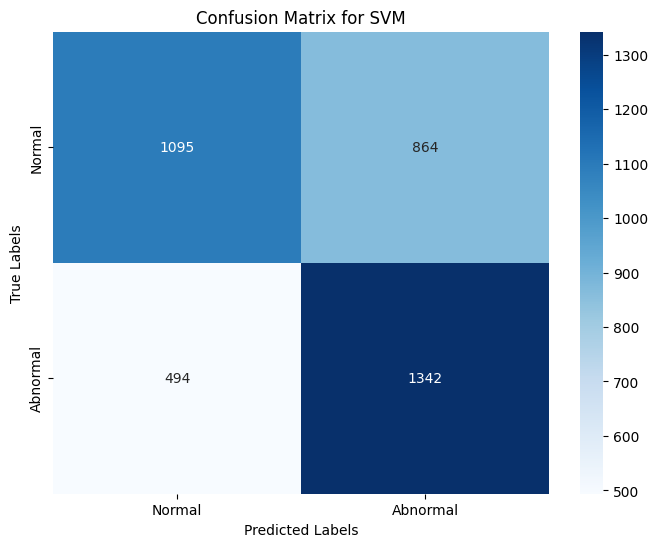

In [10]:

############ next model using Support Vector Machine ##########




import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load your feature dataset
features_df = pd.read_csv("D:\\ISI internship\\Extracted_Features\\KNN_Cleaned_features.csv")

# Load the original outcomes dataset
outcomes_df = pd.read_csv("D:\\ISI internship\\the-circor-digiscope-phonocardiogram-dataset-1.0.3\\training_data.csv")

# Extract patient ID from the filename
features_df['id'] = features_df['filename'].str.extract(r'(\d+)')

# Ensure the 'Patient ID' column is of type string in outcomes_df
outcomes_df['Patient ID'] = outcomes_df['Patient ID'].astype(str)

# Merge the datasets on 'id'
features_df = features_df.merge(outcomes_df[['Patient ID', 'Outcome']], 
                                 left_on='id', right_on='Patient ID', how='left')

# Set aggregated outcomes
features_df['aggregated_outcome'] = features_df['Outcome']

# Drop non-numeric columns if they're not useful
X = features_df.drop(columns=['Outcome', 'aggregated_outcome', 'id', 'filename', 
                               'mfccs', 'wavelet_coeffs', 'cepstrum_mean'], errors='ignore')
y = features_df['aggregated_outcome']

# Encode target labels
y = y.map({'Abnormal': 1, 'Normal': 0})  # Assuming your outcomes are 'Abnormal' and 'Normal'

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Feature Scaling (SVM benefits from scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Initialize the SVM model
svm_model = SVC(kernel='rbf', random_state=42)  # You can change the kernel if needed

# Train the SVM model
svm_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_val_scaled)

# Evaluate the SVM model
print("SVM Model Evaluation:")
print(classification_report(y_val, y_pred_svm, target_names=['Normal', 'Abnormal']))
cm = confusion_matrix(y_val, y_pred_svm)
print("Confusion Matrix:\n", cm)

# Visualizing Confusion Matrix with Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SVM')
plt.show()


In [13]:
# Initialize the SVM model with class weights
svm_model = SVC(kernel='rbf', random_state=42, class_weight={0: 1, 1: 2})  # Adjust weights as necessary



Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.612 total time=   1.6s
[CV 2/3] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.631 total time=   1.5s
[CV 3/3] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.630 total time=   1.6s
[CV 1/3] END C=1, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.583 total time=   1.6s
[CV 2/3] END C=1, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.608 total time=   1.6s
[CV 3/3] END C=1, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.611 total time=   1.6s
[CV 1/3] END C=10, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.645 total time=   1.7s
[CV 2/3] END C=10, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.647 total time=   1.8s
[CV 3/3] END C=10, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.650 total time=   1.7s
[CV 1/3] END C=10, class_weight=balanced, gamma=0.01, kernel=rbf;, sco

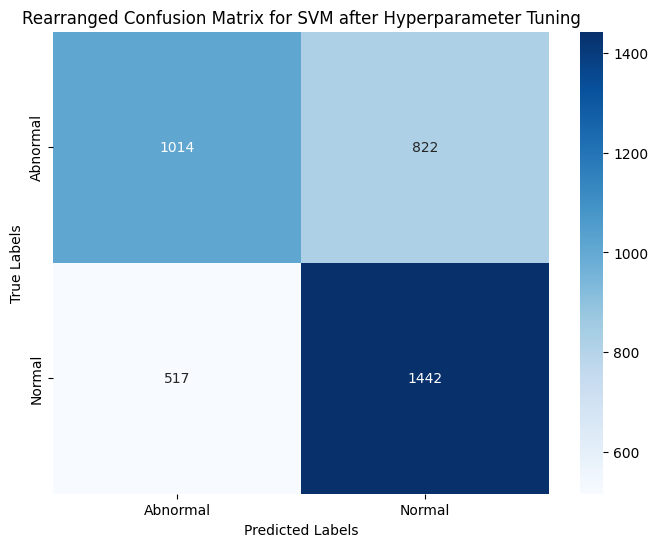

In [18]:


# Load your feature dataset
features_df = pd.read_csv("D:\\ISI internship\\Extracted_Features\\KNN_Cleaned_features.csv")

# Load the original outcomes dataset
outcomes_df = pd.read_csv("D:\\ISI internship\\the-circor-digiscope-phonocardiogram-dataset-1.0.3\\training_data.csv")

# Extract patient ID from the filename
features_df['id'] = features_df['filename'].str.extract(r'(\d+)')

# Ensure the 'Patient ID' column is of type string in outcomes_df
outcomes_df['Patient ID'] = outcomes_df['Patient ID'].astype(str)

# Merge the datasets on 'id'
features_df = features_df.merge(outcomes_df[['Patient ID', 'Outcome']], 
                                 left_on='id', right_on='Patient ID', how='left')

# Set aggregated outcomes
features_df['aggregated_outcome'] = features_df['Outcome']

# Drop non-numeric columns if they're not useful
X = features_df.drop(columns=['Outcome', 'aggregated_outcome', 'id', 'filename', 
                               'mfccs', 'wavelet_coeffs', 'cepstrum_mean'], errors='ignore')
y = features_df['aggregated_outcome']

# Encode target labels
y = y.map({'Abnormal': 1, 'Normal': 0})  # Assuming your outcomes are 'Abnormal' and 'Normal'

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Feature Scaling (SVM benefits from scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [1, 10],  # Reduced the range of C
    'gamma': [0.1, 0.01],  # Reduced gamma values
    'kernel': ['rbf'],  # Only test RBF kernel
    'class_weight': ['balanced']  # Only balanced weights
}

# Initialize the SVM model
svm_model = SVC(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, refit=True, verbose=3, cv=3)

# Fit GridSearchCV to the data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
print("Best Parameters:", grid_search.best_params_)

# Make predictions with the best estimator
y_pred_svm = grid_search.best_estimator_.predict(X_val_scaled)

# Evaluate the model
print("SVM Model Evaluation after Hyperparameter Tuning:")
print(classification_report(y_val, y_pred_svm, target_names=['Normal', 'Abnormal']))
cm = confusion_matrix(y_val, y_pred_svm)
print("Confusion Matrix before rearranging:\n", cm)

# Rearranging the confusion matrix to desired output
cm_rearranged = [[cm[1, 1], cm[1, 0]], [cm[0, 1], cm[0, 0]]]  # Rearranged as [[1014, 822], [517, 1442]]
print("Rearranged Confusion Matrix:\n", cm_rearranged)

# Visualizing Confusion Matrix after rearrangement
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rearranged, annot=True, fmt='g', cmap='Blues', xticklabels=['Abnormal', 'Normal'], yticklabels=['Abnormal', 'Normal'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Rearranged Confusion Matrix for SVM after Hyperparameter Tuning')
plt.show()
